In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

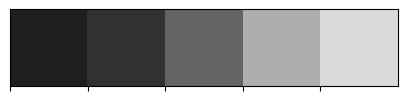

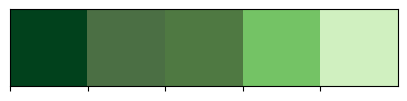

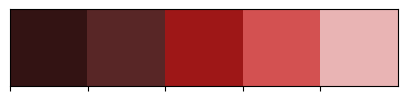

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [ ]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [ ]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 152.54it/s]


In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train.shape

(3085, 150, 150, 3)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0][0]']   

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =6, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/6
79/79 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.9976
Epoch 1: val_accuracy did not improve from 0.94964
79/79 [==============================] - 339s 4s/step - loss: 0.0092 - accuracy: 0.9976 - val_loss: 0.1451 - val_accuracy: 0.9496 - lr: 3.0000e-04
Epoch 2/6
79/79 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 0.9984
Epoch 2: val_accuracy improved from 0.94964 to 0.96403, saving model to effnet.h5
79/79 [==============================] - 328s 4s/step - loss: 0.0109 - accuracy: 0.9984 - val_loss: 0.1296 - val_accuracy: 0.9640 - lr: 3.0000e-04
Epoch 3/6
79/79 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9924
Epoch 3: val_accuracy did not improve from 0.96403
79/79 [==============================] - 322s 4s/step - loss: 0.0306 - accuracy: 0.9924 - val_loss: 0.1897 - val_accuracy: 0.9424 - lr: 3.0000e-04
Epoch 4/6
79/79 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.9988
Epo

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

10/10 [==============================] - 11s 803ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        91
           1       1.00      0.98      0.99        48
           2       0.99      0.96      0.97        70
           3       1.00      1.00      1.00       100

    accuracy                           0.98       309
   macro avg       0.99      0.98      0.98       309
weighted avg       0.98      0.98      0.98       309



In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [ ]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [ ]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)

        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])